***
## Table of Contents
<br>
  <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">1. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">2. Oversampling </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">3. Undersampling</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">4.Feature Transformation with feature selection</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">5.Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
       
</ol>
     <br>

In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display,clear_output,HTML
import warnings
warnings.filterwarnings("ignore")

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
warnings.simplefilter("ignore", DeprecationWarning)
import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics



from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score,matthews_corrcoef

from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats

Using TensorFlow backend.


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
    m['Features']=m['Features'].str.replace("dom_function_","")
    m['Features']=m['Features'].str.replace("js_function_","")
    m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
    m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [3]:
def uni_value(data):
    lst=[]
    for col in data.columns[:]:
        lst.append([col,dict(data[col].value_counts()),data[col].value_counts().values[0]>=len(data)*0.95])
    col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
    col_values.set_index('Feature',drop=True,inplace=True)
    del lst
    return col_values

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

def remove_feat(data):
    col_no_unique=[]
    for col in data.columns[:]:
        if len(data[col].value_counts())<=1:
#             print(col)
            col_no_unique.append(col)
    return col_no_unique

### Generate plot for class balance for categorical nature
def class_bal(data,title=''):
    d = [go.Bar(x=data.Target.value_counts().index.values,
               y=data.Target.value_counts().values,
               text=data.Target.value_counts().values,
               textposition = 'outside',
            )]
    layout = go.Layout(title=title,xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
    fig = go.Figure(data=d, layout=layout)
    iplot(fig)

In [4]:
def model_build(model,X_train,Y_train,X_test,Y_test,tree=False,feat=None):
    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    
    print("Accuracy of the model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    mcc=matthews_corrcoef(Y_test,y_pred_test)
    if tree==True:
        feat_impt_plot(model.feature_importances_,feat)
        return model,cm_train,cm_test,acc_train,acc_test,roc_auc,model.feature_importances_,mcc
    
    return model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    return model_build(knn,X_train,Y_train,X_test,Y_test)

def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression()
    log.fit(X_train,Y_train)
    
    return model_build(log,X_train,Y_train,X_test,Y_test)

def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier()
    rf.fit(X_train,Y_train)

    
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier()
    ada.fit(X_train,Y_train)
    
    return model_build(ada,X_train,Y_train,X_test,Y_test,True,feat)

def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier()
    gbc.fit(X_train,Y_train)
    
    return model_build(gbc,X_train,Y_train,X_test,Y_test,True,feat)

def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier()
    ext_tree.fit(X_train,Y_train)
    
    return model_build(ext_tree,X_train,Y_train,X_test,Y_test,True,feat)

def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier()
    bagging.fit(X_train,Y_train)
    
    return model_build(bagging,X_train,Y_train,X_test,Y_test)

def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    mcc=matthews_corrcoef(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

In [5]:
df_html=pd.read_csv('../html/HTML.csv',index_col='domain')
df_html.drop(['Unnamed: 0'],axis=1,inplace=True)
cookie=[col for col in df_html.columns if 'number' in col]
df_html.drop(cookie,axis=1,inplace=True)
print("Shape of our dataset:",df_html.shape)

Shape of our dataset: (43491, 1461)


In [6]:
df_js=pd.read_csv('Javascript.csv',low_memory=False,index_col='domain')

cookie=[col for col in df_js.columns if 'number' in col]
df_js.drop(cookie,axis=1,inplace=True)

df_js.rename(columns={'Malicious':'Target'},inplace=True)
print("Shape of our dataset:",df_js.shape)

Shape of our dataset: (43294, 401)


In [13]:
df_html['Num_of_hrefs']=df_html[['a_href_absolute',
 'area_href_absolute',
 'base_href_absolute',
 'link_href_absolute','a_href_relative',
 'area_href_relative',
 'base_href_relative',
 'link_href_relative']].sum(axis=1)

In [14]:
fin_col=['js_function_.replace(',
'dom_function_window.addEventListener(',
'js_function_.concat(',
'dom_function_document.createElement(',
'js_function_encodeURIComponent(',
'js_function_decodeURIComponent(',
'js_function_.substring(',
'js_function_.charAt(',
'dom_function_document.write(',
'js_function_.charCodeAt(',
'js_function_escape(',
'js_function_eval(',
'js_function_.exec(',
'js_function_String.fromCharCode(',
'js_function_.link(',
'js_function_parseInt(',
'dom_function_window.setTimeout(',
'dom_function_window.setInterval(',
'js_function_unescape(',
'js_function_.search(',
'iframe_count',         
'iframe_src_relative',         
'meta_http-equiv_X-UA-Compatible',        
'img_src_out_of_domain',         
'img_src_absolute',         
'script_type_text/javascript',         
'script_src_out_of_domain',        
'script_count',
'small_count', 
'div_count',
'iframe_hidden_true',
'image_count',
'a_count',
'input_count',
'li_count',
'style_count',    
'meta_http-equiv_refresh',
'embed_count',
'object_count',
'Num_of_hrefs']

In [15]:
df_int=pd.merge(df_js,df_html,left_index=True,right_index=True)

df=df_int.copy(deep=True)
df['Target']=df[['Target_x','Target_y']].apply(max,axis=1)

fin_col.append('Target')
df_sel=df[fin_col]

In [16]:
df_sel.Target=df_sel.Target.apply(lambda x: 1 if x=='Malicious' else 0)

train=df_sel.iloc[:32567,:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=df_sel.iloc[32567:,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)

In [19]:
# fin_col=df_sel.columns.values.tolist()
fin_col.remove('Target')

In [20]:
display(fin_col)
columns=copy.deepcopy(fin_col)

['js_function_.replace(',
 'dom_function_window.addEventListener(',
 'js_function_.concat(',
 'dom_function_document.createElement(',
 'js_function_encodeURIComponent(',
 'js_function_decodeURIComponent(',
 'js_function_.substring(',
 'js_function_.charAt(',
 'dom_function_document.write(',
 'js_function_.charCodeAt(',
 'js_function_escape(',
 'js_function_eval(',
 'js_function_.exec(',
 'js_function_String.fromCharCode(',
 'js_function_.link(',
 'js_function_parseInt(',
 'dom_function_window.setTimeout(',
 'dom_function_window.setInterval(',
 'js_function_unescape(',
 'js_function_.search(',
 'iframe_count',
 'iframe_src_relative',
 'meta_http-equiv_X-UA-Compatible',
 'img_src_out_of_domain',
 'img_src_absolute',
 'script_type_text/javascript',
 'script_src_out_of_domain',
 'script_count',
 'small_count',
 'div_count',
 'iframe_hidden_true',
 'image_count',
 'a_count',
 'input_count',
 'li_count',
 'style_count',
 'meta_http-equiv_refresh',
 'embed_count',
 'object_count',
 'Num_of_hr

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [21]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC'])

In [22]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.871495685817
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27684   154    27838
True        4031   698     4729
__all__    31715   852    32567

Accuracy of the model for test data is: 0.864161139769
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6885    55     6940
True        1051   151     1202
__all__     7936   206     8142



Logistic Regression
Accuracy of the model for training data is: 0.855590014432
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27768    70    27838
True        4633    96     4729
__all__    32401   166    32567

Accuracy of the model for test data is: 0.852001965119
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6916    24     6940
True        1181    21     1202
__all__     8097    45     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.907820800197
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24953  2885    27838
True         117  4612     4729
__all__    25070  7497    32567

Accuracy of the model for test data is: 0.895725865881
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6205   735     6940
True         114  1088     1202
__all__     6319  1823     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.875118985476
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24644  3194    27838
True         873  3856     4729
__all__    25517  7050    32567

Accuracy of the model for test data is: 0.876320314419
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6147   793     6940
True         214   988     1202
__all__     6361  1781     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.892068658458
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24943  2895    27838
True         620  4109     4729
__all__    25563  7004    32567

Accuracy of the model for test data is: 0.889830508475
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6211   729     6940
True         168  1034     1202
__all__     6379  1763     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.910000921178
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24960  2878    27838
True          53  4676     4729
__all__    25013  7554    32567

Accuracy of the model for test data is: 0.896217145664
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6205   735     6940
True         110  1092     1202
__all__     6315  1827     8142



Bagging Classifier
Accuracy of the model for training data is: 0.907360211257
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24955  2883    27838
True         134  4595     4729
__all__    25089  7478    32567

Accuracy of the model for test data is: 0.896094325718
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6203   737     6940
True         109  1093     1202
__all__     6312  1830     8142



Neural Network-1
The accuracy of the model on training data is: 0.890717597577


Predicted  False  True  __all__
Actual                         
False      24920  2918    27838
True         641  4088     4729
__all__    25561  7006    32567

The accuracy of the model on test data is: 0.883321051339


Predicted  False  True  __all__
Actual                         
False       6186   754     6940
True         196  1006     1202
__all__     6382  1760     8142

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [23]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [24]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.871496,698.0,27684.0,154.0,4031.0,0.005532,0.852400
LogisticRegression,0.855590,96.0,27768.0,70.0,4633.0,0.002515,0.979700
RandomForestClassifier,0.907821,4612.0,24953.0,2885.0,117.0,0.103635,0.024741
AdaBoostClassifier,0.875119,3856.0,24644.0,3194.0,873.0,0.114735,0.184606
GradientBoostingClassifier,0.892069,4109.0,24943.0,2895.0,620.0,0.103995,0.131106
ExtraTreeClassifier,0.910001,4676.0,24960.0,2878.0,53.0,0.103384,0.011207
BaggingClassifier,0.907360,4595.0,24955.0,2883.0,134.0,0.103563,0.028336
Neural Network-1,0.890718,4088.0,24920.0,2918.0,641.0,0.104821,0.135547


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC
index,,,,,,,,,
KNeighborsClassifier,0.864161,151.0,6885.0,55.0,1051.0,0.007925,0.874376,0.558849,0.265870
LogisticRegression,0.852002,21.0,6916.0,24.0,1181.0,0.003458,0.982529,0.507006,0.067048
RandomForestClassifier,0.895726,1088.0,6205.0,735.0,114.0,0.105908,0.094842,0.899625,0.680138
AdaBoostClassifier,0.876320,988.0,6147.0,793.0,214.0,0.114265,0.178037,0.853849,0.607275
GradientBoostingClassifier,0.889831,1034.0,6211.0,729.0,168.0,0.105043,0.139767,0.877595,0.650408
ExtraTreeClassifier,0.896217,1092.0,6205.0,735.0,110.0,0.105908,0.091514,0.901289,0.682438
BaggingClassifier,0.896094,1093.0,6203.0,737.0,109.0,0.106196,0.090682,0.901561,0.682503
Neural Network-1,0.883321,1006.0,6186.0,754.0,196.0,0.108646,0.163062,0.901561,0.627629


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [25]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 2. OverSampling </a>

In [26]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(scaled_X_train,train_Y)

/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning:

Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.



In [27]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [28]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.926162080609
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24268   3570    27838
True         541  27297    27838
__all__    24809  30867    55676

Accuracy of the model for test data is: 0.869442397445
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5965   975     6940
True          88  1114     1202
__all__     6053  2089     8142



Logistic Regression
Accuracy of the model for training data is: 0.879229829729
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      22307   5531    27838
True        1193  26645    27838
__all__    23500  32176    55676

Accuracy of the model for test data is: 0.822893637927
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5556  1384     6940
True          58  1144     1202
__all__     5614  2528     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.946027013435
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24905   2933    27838
True          72  27766    27838
__all__    24977  30699    55676

Accuracy of the model for test data is: 0.894743306313
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6176   764     6940
True          93  1109     1202
__all__     6269  1873     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.897316617573
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      23557   4281    27838
True        1436  26402    27838
__all__    24993  30683    55676

Accuracy of the model for test data is: 0.858511422255
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5873  1067     6940
True          85  1117     1202
__all__     5958  2184     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.915044184209
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24167   3671    27838
True        1059  26779    27838
__all__    25226  30450    55676

Accuracy of the model for test data is: 0.873986735446
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6011   929     6940
True          97  1105     1202
__all__     6108  2034     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.946799339033
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24913   2925    27838
True          37  27801    27838
__all__    24950  30726    55676

Accuracy of the model for test data is: 0.895480225989
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6186   754     6940
True          97  1105     1202
__all__     6283  1859     8142



Bagging Classifier
Accuracy of the model for training data is: 0.945739636468
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      24900   2938    27838
True          83  27755    27838
__all__    24983  30693    55676

Accuracy of the model for test data is: 0.892164087448
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6155   785     6940
True          93  1109     1202
__all__     6248  1894     8142



Neural Network-1
The accuracy of the model on training data is: 0.931568359796


Predicted  False   True  __all__
Actual                          
False      24170   3668    27838
True         142  27696    27838
__all__    24312  31364    55676

The accuracy of the model on test data is: 0.872512896094


Predicted  False  True  __all__
Actual                         
False       5976   964     6940
True          74  1128     1202
__all__     6050  2092     8142

### <a id='2.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [29]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [30]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.926162,27297.0,24268.0,3570.0,541.0,0.128242,0.019434
LogisticRegression,0.879230,26645.0,22307.0,5531.0,1193.0,0.198685,0.042855
RandomForestClassifier,0.946027,27766.0,24905.0,2933.0,72.0,0.105360,0.002586
AdaBoostClassifier,0.897317,26402.0,23557.0,4281.0,1436.0,0.153783,0.051584
GradientBoostingClassifier,0.915044,26779.0,24167.0,3671.0,1059.0,0.131870,0.038042
ExtraTreeClassifier,0.946799,27801.0,24913.0,2925.0,37.0,0.105072,0.001329
BaggingClassifier,0.945740,27755.0,24900.0,2938.0,83.0,0.105539,0.002982
Neural Network-1,0.931568,27696.0,24170.0,3668.0,142.0,0.131762,0.005101


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.869442,1114.0,5965.0,975.0,88.0,0.140490,0.073211,0.893149,0.638653
LogisticRegression,0.822894,1144.0,5556.0,1384.0,58.0,0.199424,0.048253,0.876162,0.576782
RandomForestClassifier,0.894743,1109.0,6176.0,764.0,93.0,0.110086,0.077371,0.906271,0.684873
AdaBoostClassifier,0.858511,1117.0,5873.0,1067.0,85.0,0.153746,0.070715,0.887769,0.620953
GradientBoostingClassifier,0.873987,1105.0,6011.0,929.0,97.0,0.133862,0.080699,0.892720,0.643605
ExtraTreeClassifier,0.895480,1105.0,6186.0,754.0,97.0,0.108646,0.080699,0.905328,0.685086
BaggingClassifier,0.892164,1109.0,6155.0,785.0,93.0,0.113112,0.077371,0.904758,0.679669
Neural Network-1,0.872513,1128.0,5976.0,964.0,74.0,0.138905,0.061564,0.904758,0.649096


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [31]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='3' style="text-decoration : none; color : #000000;"> 3. Undersampling</a>

In [32]:
df_non=train[train.Target==0]
df_mal=train[train.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X_train=df_u[columns]
X_train=scaler.transform(X_train)
Y_train=df_u.Target.values

print("Shape after undersampling",X_train.shape)


Shape after undersampling (9458, 40)


In [33]:
## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [34]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.559420596321
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4585   144     4729
True        4023   706     4729
__all__     8608   850     9458

Accuracy of the model for test data is: 0.832350773766
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6632   308     6940
True        1057   145     1202
__all__     7689   453     8142



Logistic Regression
Accuracy of the model for training data is: 0.873969126665
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3750   979     4729
True         213  4516     4729
__all__     3963  5495     9458

Accuracy of the model for test data is: 0.818717759764
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5520  1420     6940
True          56  1146     1202
__all__     5576  2566     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.941002326073
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4228   501     4729
True          57  4672     4729
__all__     4285  5173     9458

Accuracy of the model for test data is: 0.88479489069
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6084   856     6940
True          82  1120     1202
__all__     6166  1976     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.888559949249
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       3958   771     4729
True         283  4446     4729
__all__     4241  5217     9458

Accuracy of the model for test data is: 0.85470400393
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5834  1106     6940
True          77  1125     1202
__all__     5911  2231     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.904948192007
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4077   652     4729
True         247  4482     4729
__all__     4324  5134     9458

Accuracy of the model for test data is: 0.869688037337
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       5954   986     6940
True          75  1127     1202
__all__     6029  2113     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.946077394798
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4230   499     4729
True          11  4718     4729
__all__     4241  5217     9458

Accuracy of the model for test data is: 0.887374109555
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6100   840     6940
True          77  1125     1202
__all__     6177  1965     8142



Bagging Classifier
Accuracy of the model for training data is: 0.941425248467
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       4217   512     4729
True          42  4687     4729
__all__     4259  5199     9458

Accuracy of the model for test data is: 0.878531073446
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6023   917     6940
True          72  1130     1202
__all__     6095  2047     8142



Neural Network-1
The accuracy of the model on training data is: 0.91636709665


Predicted  False  True  __all__
Actual                         
False       4032   697     4729
True          94  4635     4729
__all__     4126  5332     9458

The accuracy of the model on test data is: 0.846106607713


Predicted  False  True  __all__
Actual                         
False       5746  1194     6940
True          59  1143     1202
__all__     5805  2337     8142

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [35]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [36]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.559421,706.0,4585.0,144.0,4023.0,0.030450,0.850708
LogisticRegression,0.873969,4516.0,3750.0,979.0,213.0,0.207021,0.045041
RandomForestClassifier,0.941002,4672.0,4228.0,501.0,57.0,0.105942,0.012053
AdaBoostClassifier,0.888560,4446.0,3958.0,771.0,283.0,0.163037,0.059844
GradientBoostingClassifier,0.904948,4482.0,4077.0,652.0,247.0,0.137873,0.052231
ExtraTreeClassifier,0.946077,4718.0,4230.0,499.0,11.0,0.105519,0.002326
BaggingClassifier,0.941425,4687.0,4217.0,512.0,42.0,0.108268,0.008881
Neural Network-1,0.916367,4635.0,4032.0,697.0,94.0,0.147388,0.019877


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.832351,145.0,6632.0,308.0,1057.0,0.044380,0.879368,0.538126,0.118004
LogisticRegression,0.818718,1146.0,5520.0,1420.0,56.0,0.204611,0.046589,0.874400,0.571753
RandomForestClassifier,0.884795,1120.0,6084.0,856.0,82.0,0.123343,0.068220,0.904219,0.668934
AdaBoostClassifier,0.854704,1125.0,5834.0,1106.0,77.0,0.159366,0.064060,0.888287,0.617639
GradientBoostingClassifier,0.869688,1127.0,5954.0,986.0,75.0,0.142075,0.062396,0.897765,0.643748
ExtraTreeClassifier,0.887374,1125.0,6100.0,840.0,77.0,0.121037,0.064060,0.907451,0.675566
BaggingClassifier,0.878531,1130.0,6023.0,917.0,72.0,0.132133,0.059900,0.903984,0.660663
Neural Network-1,0.846107,1143.0,5746.0,1194.0,59.0,0.172046,0.049085,0.903984,0.610753


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [37]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='4' style="text-decoration : none; color : #000000;">4. Feature Transformation with feature selection </a>

In [ ]:
df.Target=df.Target.apply(lambda x: 1 if x=='Malicious' else 0)

In [38]:
df_sel.Target.value_counts()

0    34778
1     5931
Name: Target, dtype: int64

In [ ]:
df_sel.reset_index(inplace=True)

# columns=columns.tolist()
columns.append('domain')

df_min=df_sel[columns]

es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

In [40]:
df_sel.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df_sel.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

In [41]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [42]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

In [43]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [44]:
rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

In [45]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

In [46]:
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [47]:
X=fs[feature_selection_df[feature_selection_df.Total>=4]['Feature']]
X.fillna(value=0,inplace=True)
X.replace([np.inf,-np.inf],0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(40709, 25)

In [48]:
print('Features we will be using:\n')
display(feature_name)

Features we will be using:



['script_src_out_of_domain / script_count',
 'script_src_out_of_domain + script_type_text/javascript',
 'script_count + style_count',
 'meta_http-equiv_refresh + script_count',
 'meta_http-equiv_X-UA-Compatible + script_count',
 'js_function_unescape( + script_count',
 'js_function_parseInt( + script_count',
 'js_function_escape( + script_count',
 'js_function_encodeURIComponent( + script_count',
 'js_function_decodeURIComponent( + script_count',
 'js_function_String.fromCharCode( + script_count',
 'js_function_.substring( + script_count',
 'js_function_.search( + script_count',
 'js_function_.replace( + script_count',
 'js_function_.link( + script_count',
 'js_function_.exec( + script_count',
 'js_function_.charCodeAt( + script_count',
 'js_function_.charAt( + script_count',
 'image_count + script_count',
 'iframe_src_relative + script_count',
 'iframe_count + script_count',
 'dom_function_window.setInterval( + script_count',
 'dom_function_window.addEventListener( + script_count',
 '

In [49]:
fs=fs.reindex(df_sel.index.values)
fs.fillna(value=0,inplace=True)
fs.replace([np.inf,-np.inf],0,inplace=True)

In [50]:
train=fs.iloc[:32567]
train_Y=train.Target.values
train_X=train[feature_name].values


scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=fs.iloc[32567:]
test_Y=test.Target.values
test_X=test[feature_name]

scaled_X_test=scaler.transform(test_X)

In [51]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [52]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.868118033592
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      27613   225    27838
True        4070   659     4729
__all__    31683   884    32567

Accuracy of the model for test data is: 0.861950380742
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6875    65     6940
True        1059   143     1202
__all__     7934   208     8142



Logistic Regression
Accuracy of the model for training data is: 0.879387109651
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24925  2913    27838
True        1015  3714     4729
__all__    25940  6627    32567

Accuracy of the model for test data is: 0.881110292311
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6221   719     6940
True         249   953     1202
__all__     6470  1672     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.903767617527
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24912  2926    27838
True         208  4521     4729
__all__    25120  7447    32567

Accuracy of the model for test data is: 0.892778187178
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6196   744     6940
True         129  1073     1202
__all__     6325  1817     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.871710627322
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24421  3417    27838
True         761  3968     4729
__all__    25182  7385    32567

Accuracy of the model for test data is: 0.873004175878
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6097   843     6940
True         191  1011     1202
__all__     6288  1854     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.890533361992
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24955  2883    27838
True         682  4047     4729
__all__    25637  6930    32567

Accuracy of the model for test data is: 0.890444608204
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6224   716     6940
True         176  1026     1202
__all__     6400  1742     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.906131974084
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24923  2915    27838
True         142  4587     4729
__all__    25065  7502    32567

Accuracy of the model for test data is: 0.89179562761
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6190   750     6940
True         131  1071     1202
__all__     6321  1821     8142



Bagging Classifier
Accuracy of the model for training data is: 0.904105382749
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24905  2933    27838
True         190  4539     4729
__all__    25095  7472    32567

Accuracy of the model for test data is: 0.89240972734
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6184   756     6940
True         120  1082     1202
__all__     6304  1838     8142



Neural Network-1
The accuracy of the model on training data is: 0.857278840524


Predicted  False  True  __all__
Actual                         
False      27806    32    27838
True        4616   113     4729
__all__    32422   145    32567

The accuracy of the model on test data is: 0.854581183984


Predicted  False  True  __all__
Actual                         
False       6934     6     6940
True        1178    24     1202
__all__     8112    30     8142

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [53]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [54]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.868118,659.0,27613.0,225.0,4070.0,0.008082,0.860647
LogisticRegression,0.879387,3714.0,24925.0,2913.0,1015.0,0.104641,0.214633
RandomForestClassifier,0.903768,4521.0,24912.0,2926.0,208.0,0.105108,0.043984
AdaBoostClassifier,0.871711,3968.0,24421.0,3417.0,761.0,0.122746,0.160922
GradientBoostingClassifier,0.890533,4047.0,24955.0,2883.0,682.0,0.103563,0.144217
ExtraTreeClassifier,0.906132,4587.0,24923.0,2915.0,142.0,0.104713,0.030027
BaggingClassifier,0.904105,4539.0,24905.0,2933.0,190.0,0.105360,0.040178
Neural Network-1,0.857279,113.0,27806.0,32.0,4616.0,0.001150,0.976105


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.861950,143.0,6875.0,65.0,1059.0,0.009366,0.881032,0.554801,0.246419
LogisticRegression,0.881110,953.0,6221.0,719.0,249.0,0.103602,0.207155,0.844621,0.605249
RandomForestClassifier,0.892778,1073.0,6196.0,744.0,129.0,0.107205,0.107321,0.892737,0.669200
AdaBoostClassifier,0.873004,1011.0,6097.0,843.0,191.0,0.121470,0.158902,0.859814,0.608736
GradientBoostingClassifier,0.890445,1026.0,6224.0,716.0,176.0,0.103170,0.146423,0.875204,0.649105
ExtraTreeClassifier,0.891796,1071.0,6190.0,750.0,131.0,0.108069,0.108985,0.891473,0.666524
BaggingClassifier,0.892410,1082.0,6184.0,756.0,120.0,0.108934,0.099834,0.895616,0.671360
Neural Network-1,0.854581,24.0,6934.0,6.0,1178.0,0.000865,0.980033,0.895616,0.111838


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [55]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

### <a id='5' style="text-decoration : none; color : #000000;">5. Feature Transformation with PCA </a>

In [56]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

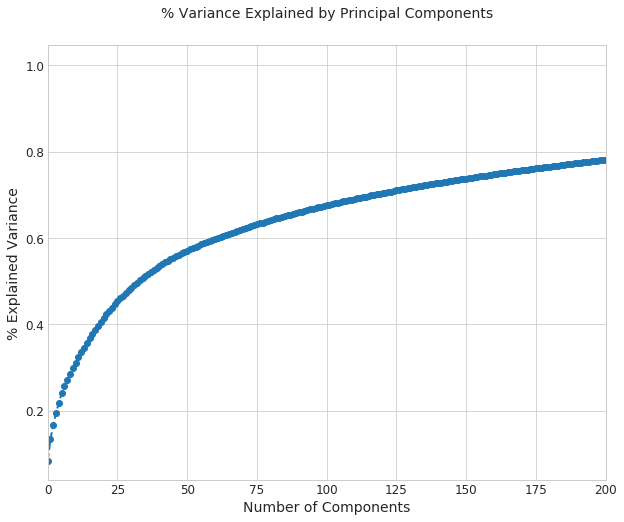

In [57]:
sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [62]:
# np.where(np.cumsum(pca.explained_variance_ratio_)>=0.8)[0]

In [59]:
pca=PCA(n_components=228,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 228 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 228 components is: 0.798989488146


In [60]:
X_train=X_pca_21[:32567]
Y_train=fs.iloc[:32567]['Target'].values
X_test=X_pca_21[32567:]
Y_test=fs.iloc[32567:]['Target'].values

## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [63]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,228).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.896398194491
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24850  2988    27838
True         386  4343     4729
__all__    25236  7331    32567

Accuracy of the model for test data is: 0.890813068042
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6166   774     6940
True         115  1087     1202
__all__     6281  1861     8142



Logistic Regression
Accuracy of the model for training data is: 0.880523229036
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24853  2985    27838
True         906  3823     4729
__all__    25759  6808    32567

Accuracy of the model for test data is: 0.87963645296
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6177   763     6940
True         217   985     1202
__all__     6394  1748     8142



RandomForest Classifier
Accuracy of the model for training data is: 0.907697976479
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24954  2884    27838
True         122  4607     4729
__all__    25076  7491    32567

Accuracy of the model for test data is: 0.896462785556
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6210   730     6940
True         113  1089     1202
__all__     6323  1819     8142



Adaoost Classifier
Accuracy of the model for training data is: 0.884238646483
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24847  2991    27838
True         779  3950     4729
__all__    25626  6941    32567

Accuracy of the model for test data is: 0.885040530582
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6200   740     6940
True         196  1006     1202
__all__     6396  1746     8142



GradientBoosting Classifier
Accuracy of the model for training data is: 0.896766665643
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24964  2874    27838
True         488  4241     4729
__all__    25452  7115    32567

Accuracy of the model for test data is: 0.893760746745
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6212   728     6940
True         137  1065     1202
__all__     6349  1793     8142



ExtraTree Classifier
Accuracy of the model for training data is: 0.910000921178
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24960  2878    27838
True          53  4676     4729
__all__    25013  7554    32567

Accuracy of the model for test data is: 0.896462785556
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6208   732     6940
True         111  1091     1202
__all__     6319  1823     8142



Bagging Classifier
Accuracy of the model for training data is: 0.908005035772
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      24955  2883    27838
True         113  4616     4729
__all__    25068  7499    32567

Accuracy of the model for test data is: 0.895971505773
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       6203   737     6940
True         110  1092     1202
__all__     6313  1829     8142



Neural Network-1
The accuracy of the model on training data is: 0.904719501345


Predicted  False  True  __all__
Actual                         
False      24900  2938    27838
True         165  4564     4729
__all__    25065  7502    32567

The accuracy of the model on test data is: 0.890076148366


Predicted  False  True  __all__
Actual                         
False       6169   771     6940
True         124  1078     1202
__all__     6293  1849     8142

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [64]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [65]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.896398,4343.0,24850.0,2988.0,386.0,0.107335,0.081624
LogisticRegression,0.880523,3823.0,24853.0,2985.0,906.0,0.107228,0.191584
RandomForestClassifier,0.907698,4607.0,24954.0,2884.0,122.0,0.103599,0.025798
AdaBoostClassifier,0.884239,3950.0,24847.0,2991.0,779.0,0.107443,0.164728
GradientBoostingClassifier,0.896767,4241.0,24964.0,2874.0,488.0,0.103240,0.103193
ExtraTreeClassifier,0.910001,4676.0,24960.0,2878.0,53.0,0.103384,0.011207
BaggingClassifier,0.908005,4616.0,24955.0,2883.0,113.0,0.103563,0.023895
Neural Network-1,0.904720,4564.0,24900.0,2938.0,165.0,0.105539,0.034891


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.890813,1087.0,6166.0,774.0,115.0,0.111527,0.095674,0.896399,0.669742
LogisticRegression,0.879636,985.0,6177.0,763.0,217.0,0.109942,0.180532,0.854763,0.612975
RandomForestClassifier,0.896463,1089.0,6210.0,730.0,113.0,0.105187,0.094010,0.900401,0.681992
AdaBoostClassifier,0.885041,1006.0,6200.0,740.0,196.0,0.106628,0.163062,0.865155,0.631194
GradientBoostingClassifier,0.893761,1065.0,6212.0,728.0,137.0,0.104899,0.113977,0.890562,0.668666
ExtraTreeClassifier,0.896463,1091.0,6208.0,732.0,111.0,0.105476,0.092346,0.901089,0.682630
BaggingClassifier,0.895972,1092.0,6203.0,737.0,110.0,0.106196,0.091514,0.901145,0.681928
Neural Network-1,0.890076,1078.0,6169.0,771.0,124.0,0.111095,0.103161,0.901145,0.665297


In [66]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')